<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/SafeGraph-social-distancing-by-zipcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
colab_requirements = [
    "apt install python3-rtree=0.8.3+ds-1", # rtree v0.8.3
    "pip install geopandas==0.7.0" # geopandas v0.7.0 
]

In [2]:
# following the post, 'Making Jupyter notebooks Google Colab ready'
# https://timsainburg.com/google%20colab.html

import os, sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if 'COLAB_GPU' in os.environ: # a quick and dirty way to check whether this is COLAB
    for i in colab_requirements:
        run_subprocess_command(i)

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
python3-pkg-resources
Suggested packages:
python3-setuptools
The following NEW packages will be installed:
libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 59 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [9

In [4]:
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg
from shapely.geometry import Point

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

from pandas.plotting import scatter_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the census block groups and zipcode boundaries of Chicago

Mapping census block groups to zip code is not trivial and note recommended.

See "Stop Using Zip Codes for Geospatial Analysis", https://carto.com/blog/zip-codes-spatial-analysis/


In [5]:
cook_cbg = gpd.read_file('https://raw.githubusercontent.com/loganpowell/census-geojson/master/GeoJSON/500k/2019/17/block-group.json', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)
# select Cook county
cook_cbg = cook_cbg[cook_cbg.COUNTYFP == '031']
cook_cbg = cook_cbg[['GEOID', 'geometry']]
cook_cbg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3992 entries, 0 to 9688
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     3992 non-null   object  
 1   geometry  3992 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 93.6+ KB


In [6]:
chi_zipcode = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=GeoJSON', # zipcode
                            crs = from_epsg(2163)).to_crs(epsg = 3528)
chi_zipcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    61 non-null     object  
 1   shape_area  61 non-null     object  
 2   shape_len   61 non-null     object  
 3   zip         61 non-null     object  
 4   geometry    61 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 2.5+ KB


In [7]:
chi_cbgzip = gpd.sjoin(cook_cbg, chi_zipcode,
                    how='right',op='intersects').drop("index_left", axis = 1)
chi_cbgzip.info()
#chi_cbgzip.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3315 entries, 0 to 60
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       3315 non-null   object  
 1   objectid    3315 non-null   object  
 2   shape_area  3315 non-null   object  
 3   shape_len   3315 non-null   object  
 4   zip         3315 non-null   object  
 5   geometry    3315 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 181.3+ KB


In [8]:
# notice the difference between unique count and # of entries (2329 vs. 3315)?
# many census block groups cross the zip code boundaries ... so it's tricky
print(chi_cbgzip.GEOID.nunique())


2329


## Load the daily census-block-group away-from-home data

After loading the data,
1. Aggregate (summing the device counts) by each month / census-block group
2. Join with zip code, then aggregate by zip code.

In [9]:
# upload the processed file from the local computer
from google.colab import files
uploaded = files.upload()

Saving away_from_home_time_17031.csv to away_from_home_time_17031.csv


In [10]:
# check if the file has been successfully uploaded
!ls

away_from_home_time_17031.csv  sample_data


In [11]:
daily_df = pd.read_csv('./away_from_home_time_17031.csv')
#daily_df.head()
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186394 entries, 0 to 1186393
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   origin_census_block_group  1186394 non-null  int64 
 1   date                       1186394 non-null  object
 2   weekday                    1186394 non-null  int64 
 3   cnt_afh_total              1186394 non-null  int64 
 4   cnt_afh_<20                1186394 non-null  int64 
 5   cnt_afh_21-45              1186394 non-null  int64 
 6   cnt_afh_46-60              1186394 non-null  int64 
 7   cnt_afh_61-120             1186394 non-null  int64 
 8   cnt_afh_121-180            1186394 non-null  int64 
 9   cnt_afh_181-240            1186394 non-null  int64 
 10  cnt_afh_241-300            1186394 non-null  int64 
 11  cnt_afh_301-360            1186394 non-null  int64 
 12  cnt_afh_361-420            1186394 non-null  int64 
 13  cnt_afh_421-480            

In [12]:
# attach month
daily_df['date'] = daily_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [13]:
daily_df['month_year'] = pd.to_datetime(daily_df.date).dt.to_period('M')
daily_df.head(5)

origin_census_block_group       date  ...  cnt_afh_1321-1440  month_year
0               170310633032 2019-01-01  ...                  1     2019-01
1               170310812024 2019-01-01  ...                  1     2019-01
2               170312420003 2019-01-01  ...                  1     2019-01
3               170318428005 2019-01-01  ...                  2     2019-01
4               170318130001 2019-01-01  ...                  0     2019-01

[5 rows x 25 columns]

In [14]:
# aggregate by census-block-group and month_year
monthly_df = daily_df.groupby(['origin_census_block_group', 'month_year'], as_index=False).sum()
monthly_df['GEOID'] = monthly_df.origin_census_block_group.astype('str')
monthly_df.head()

origin_census_block_group month_year  ...  cnt_afh_1321-1440         GEOID
0               170310101001    2019-01  ...                 14  170310101001
1               170310101001    2019-02  ...                  8  170310101001
2               170310101001    2019-03  ...                 11  170310101001
3               170310101001    2019-04  ...                 47  170310101001
4               170310101001    2019-05  ...                 17  170310101001

[5 rows x 25 columns]

In [15]:
# join with zipcode
monthly_df = pd.merge(monthly_df, chi_cbgzip, 
                      left_on = "GEOID", right_on = "GEOID", 
                      how = "right")
#monthly_df.head()
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56133 entries, 0 to 56132
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   origin_census_block_group  56122 non-null  float64  
 1   month_year                 56122 non-null  period[M]
 2   weekday                    56122 non-null  float64  
 3   cnt_afh_total              56122 non-null  float64  
 4   cnt_afh_<20                56122 non-null  float64  
 5   cnt_afh_21-45              56122 non-null  float64  
 6   cnt_afh_46-60              56122 non-null  float64  
 7   cnt_afh_61-120             56122 non-null  float64  
 8   cnt_afh_121-180            56122 non-null  float64  
 9   cnt_afh_181-240            56122 non-null  float64  
 10  cnt_afh_241-300            56122 non-null  float64  
 11  cnt_afh_301-360            56122 non-null  float64  
 12  cnt_afh_361-420            56122 non-null  float64  
 13  cnt_afh_421-480 

In [17]:
# aggregate by zip code and month_year
zipcode_df = monthly_df.groupby(['zip', 'month_year'], as_index=False).sum()
zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1002
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype    
---  ------                     --------------  -----    
 0   zip                        1003 non-null   object   
 1   month_year                 1003 non-null   period[M]
 2   origin_census_block_group  1003 non-null   float64  
 3   weekday                    1003 non-null   float64  
 4   cnt_afh_total              1003 non-null   float64  
 5   cnt_afh_<20                1003 non-null   float64  
 6   cnt_afh_21-45              1003 non-null   float64  
 7   cnt_afh_46-60              1003 non-null   float64  
 8   cnt_afh_61-120             1003 non-null   float64  
 9   cnt_afh_121-180            1003 non-null   float64  
 10  cnt_afh_181-240            1003 non-null   float64  
 11  cnt_afh_241-300            1003 non-null   float64  
 12  cnt_afh_301-360            1003 non-null   float64  
 13  cnt_afh_361-420   

In [18]:
zipcode_df.head()


zip month_year  ...  cnt_afh_1201-1320  cnt_afh_1321-1440
0  60601    2019-01  ...              557.0              535.0
1  60601    2019-02  ...              499.0              425.0
2  60601    2019-03  ...              504.0              367.0
3  60601    2019-04  ...              601.0              459.0
4  60601    2019-05  ...              741.0              561.0

[5 rows x 25 columns]

## Get the mean away-from-home time for each zip code and month_year

**HOWEVER, the overall mean is very misleading** because the away-from-home time of the people who stayed more than 12 hours away-from-home actually increased after 2020 April. I will illustrate this trend below.

To address this, I simply divided the 'devices' into to groups, less-than-12h (`afh_keys-low`) and more-than-12h (`afh_keys-high`) away-from-home time, and calculated the mean away-from-home time for each.

In [19]:
afh_keys_low = ['<20', '21-45', '46-60', '61-120', '121-180',
                '181-240', '241-300', '301-360', '361-420', '421-480',
                '481-540', '541-600', '601-660', '661-720']
afh_keys_high = ['721-840', '841-960', '961-1080', '1081-1200', '1201-1320', '1321-1440']

afh_val = {'<20':10, '21-45':33, '46-60':54, '61-120':90, '121-180':150,
           '181-240':210, '241-300':270, '301-360':330, '361-420':390, '421-480':450,
           '481-540':510, '541-600':570, '601-660':630, '661-720':690, '721-840':780, 
           '841-960':900, '961-1080':1020, '1081-1200':1140, '1201-1320':1260, '1321-1440':1380}

In [20]:
# counting the # of devices
zipcode_df['devcnt_low'] = zipcode_df['cnt_afh_<20']
zipcode_df['devcnt_high'] = zipcode_df['cnt_afh_721-840']

for key in afh_keys_low[1:]:
    zipcode_df['devcnt_low'] += zipcode_df['cnt_afh_' + key]
    
for key in afh_keys_high[1:]:
    zipcode_df['devcnt_high'] += zipcode_df['cnt_afh_' + key]

print(zipcode_df.devcnt_low.describe())
print('-----------------')
print(zipcode_df.devcnt_high.describe())

count      1003.000000
mean     105646.620140
std       55728.912272
min        7532.000000
25%       69566.000000
50%       98077.000000
75%      137736.500000
max      423673.000000
Name: devcnt_low, dtype: float64
-----------------
count     1003.000000
mean     10183.483549
std       4475.582328
min       1099.000000
25%       7401.000000
50%       9854.000000
75%      12983.000000
max      35265.000000
Name: devcnt_high, dtype: float64


In [21]:
#afh_keys[1:]
#afh_val['<20']
zipcode_df['mean_afh_low'] = zipcode_df['cnt_afh_<20'] * afh_val['<20'] / zipcode_df['devcnt_low']
zipcode_df['mean_afh_high'] = zipcode_df['cnt_afh_721-840'] * afh_val['721-840'] / zipcode_df['devcnt_high']

for key in afh_keys_low[1:]:
    zipcode_df['mean_afh_low'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_low']

for key in afh_keys_high[1:]:
    zipcode_df['mean_afh_high'] += zipcode_df['cnt_afh_' + key] * afh_val[key] / zipcode_df['devcnt_high']

print(zipcode_df.mean_afh_low.describe())
print('--------------------')
print(zipcode_df.mean_afh_high.describe())

count    1003.000000
mean      149.711649
std        23.341634
min        84.657669
25%       139.619011
50%       150.409305
75%       162.943642
max       211.069481
Name: mean_afh_low, dtype: float64
--------------------
count    1003.000000
mean     1040.843048
std        44.512778
min       977.643732
25%      1010.870670
50%      1026.812996
75%      1055.355599
max      1260.177712
Name: mean_afh_high, dtype: float64


In [22]:
zipcode_df.head(10)

zip month_year  ...  mean_afh_low  mean_afh_high
0  60601    2019-01  ...    138.564193    1022.532086
1  60601    2019-02  ...    155.568782    1010.812854
2  60601    2019-03  ...    156.181377     996.229056
3  60601    2019-04  ...    160.653417    1001.839323
4  60601    2019-05  ...    148.077901    1010.891632
5  60601    2019-06  ...    139.672000    1002.269807
6  60601    2019-07  ...    135.988416    1009.223024
7  60601    2019-08  ...    143.326849    1010.807899
8  60601    2019-09  ...    142.078251    1000.676485
9  60601    2019-10  ...    143.192074    1007.938743

[10 rows x 29 columns]

## Make the summary tables

In [23]:
# rows: month_year, columns: zip code
zipsumm_low = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_low' ).reset_index()
zipsumm_low.head(10)

zip month_year       60601       60602  ...       60666       60707       60827
0      2019-01  138.564193  134.120702  ...  150.369604  143.065079  118.418349
1      2019-02  155.568782  151.075822  ...  168.958902  160.691787  133.988967
2      2019-03  156.181377  150.773415  ...  176.643925  166.237888  141.807671
3      2019-04  160.653417  153.532252  ...  180.454641  168.231335  144.627741
4      2019-05  148.077901  142.120052  ...  183.807436  174.560528  149.230096
5      2019-06  139.672000  139.742580  ...  177.982679  166.148716  141.319116
6      2019-07  135.988416  135.499061  ...  187.348566  166.817724  144.863870
7      2019-08  143.326849  136.724450  ...  200.396487  172.387337  141.172413
8      2019-09  142.078251  137.378527  ...  194.094254  177.719574  146.699337
9      2019-10  143.192074  138.318152  ...  199.177691  178.800247  148.239908

[10 rows x 60 columns]

In [24]:
# rows: month_year, columns: zip code
zipsumm_high = zipcode_df.pivot(index='month_year', columns='zip', values='mean_afh_high' ).reset_index()
zipsumm_high.head(10)

zip month_year        60601        60602  ...        60666        60707        60827
0      2019-01  1022.532086  1029.976744  ...  1009.059334  1010.092251  1013.766800
1      2019-02  1010.812854  1013.354596  ...   979.851301   997.795187  1015.342137
2      2019-03   996.229056  1011.773969  ...   994.063401   997.928606  1002.490949
3      2019-04  1001.839323  1019.046322  ...   992.411576  1020.262467  1028.645262
4      2019-05  1010.891632  1034.478449  ...   990.728571   998.107265  1007.496038
5      2019-06  1002.269807  1005.151311  ...  1001.075581  1011.370279  1020.089021
6      2019-07  1009.223024  1003.617945  ...  1027.512690  1029.495862  1034.417266
7      2019-08  1010.807899  1017.894340  ...  1006.920093  1025.021577  1027.486631
8      2019-09  1000.676485   993.544885  ...   996.399395   999.405882  1018.690909
9      2019-10  1007.938743  1007.744905  ...  1000.151583  1004.867257  1030.375940

[10 rows x 60 columns]

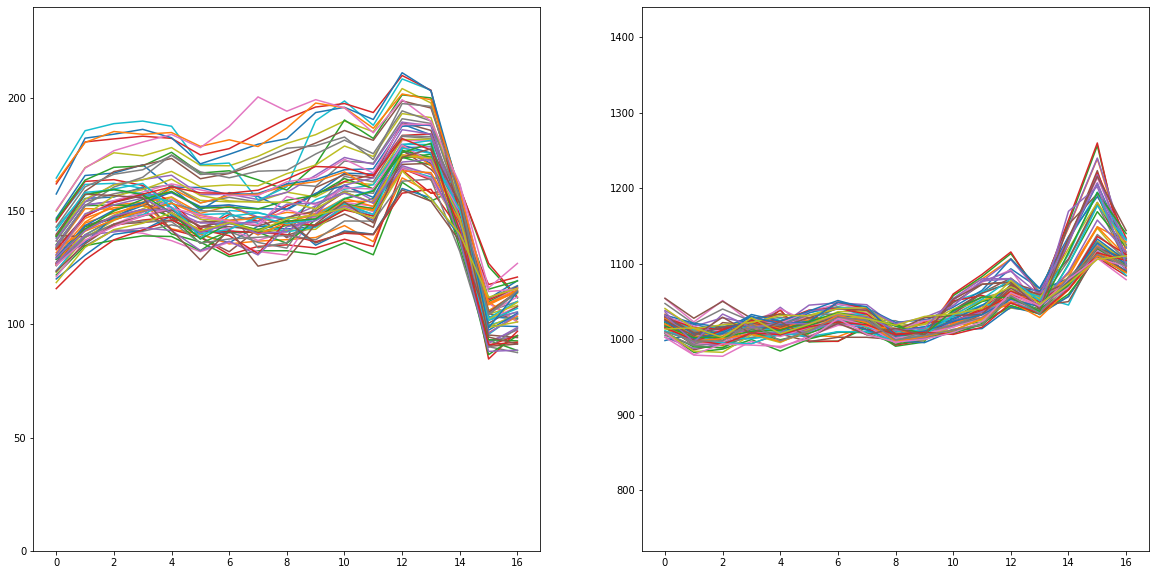

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

zipsumm_low.plot(legend=False, ax=ax[0], ylim=[0,240])
zipsumm_high.plot(legend=False, ax=ax[1], ylim=[720,1440])

In [ ]:
socdist_df['date'] = socdist_df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
socdist_df['weekday'] = socdist_df.date.apply(lambda x: x.weekday())
socdist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186394 entries, 0 to 1186393
Data columns (total 12 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   origin_census_block_group    1186394 non-null  int64         
 1   date                         1186394 non-null  datetime64[ns]
 2   device_count                 1186394 non-null  int64         
 3   distance_traveled_from_home  1186378 non-null  float64       
 4   p_completely_home            1186394 non-null  float64       
 5   p_lt_6h_out                  1186394 non-null  float64       
 6   p_6h_12h_out                 1186394 non-null  float64       
 7   p_ht_12h_out                 1186394 non-null  float64       
 8   p_part_time_work             1186394 non-null  float64       
 9   p_full_time_work             1186394 non-null  float64       
 10  p_delivery                   1186394 non-null  float64       
 11  weekday    

### The number of devices being tracked

In [ ]:
dev_cnt = socdist_df.groupby("date").sum()[['device_count']]
dev_cnt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 512 entries, 2019-01-01 to 2020-05-26
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   device_count  512 non-null    int64
dtypes: int64(1)
memory usage: 8.0 KB


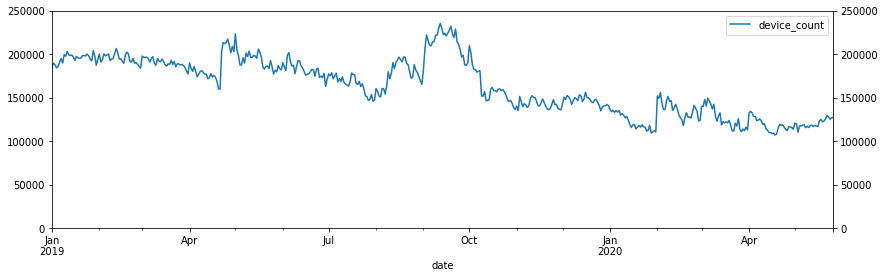

In [ ]:
ax = dev_cnt.plot(figsize = (14,4), ylim = (0,250000))
ax.tick_params(labelright=True, right=True)

### Work-related variables across time

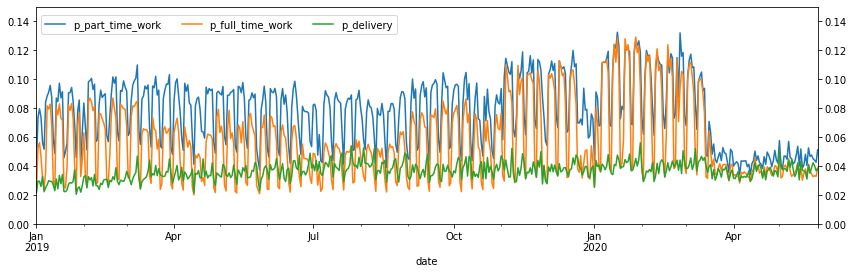

In [ ]:
prob_summ = socdist_df.groupby("date").mean()

ax = prob_summ[['p_part_time_work', 'p_full_time_work', 'p_delivery']].plot(legend = True, figsize = (14,4), ylim = (0,.15))
ax.tick_params(labelright = True, right=True)
ax.legend(loc='lower left', bbox_to_anchor=(0., .85, 1., .102), ncol=3)

### Stay-home related variables

* `p_completely_home`: Proportion of the 'devices' that did not leave the 153m x 153m home grid.
* `p_lt_6h_out`: Proportion of the devices that spent less than 6 hours outside the home grid.
* `p_6h_12h_out`: Proportion of the devices that spent 6-12 hours outside the home grid. *Perhaps reflecting full-time work.*
* `p_ht_12h_out`: Proportion of the devices that spent more than 12 hours outside the home grid. *Seems somewhat stable.*

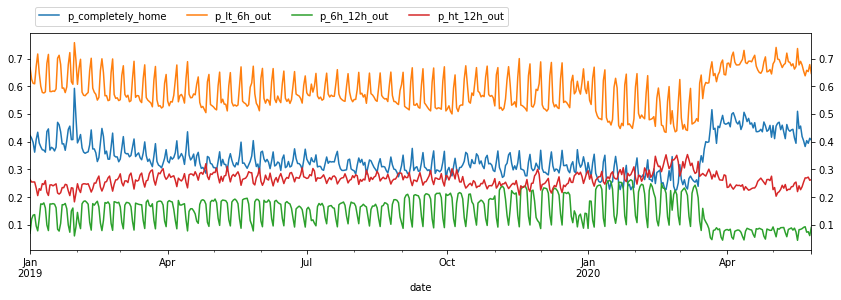

In [ ]:
ax = prob_summ[['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']].plot(legend = True, figsize = (14,4))
ax.tick_params(labelright = True, right=True)
ax.legend(loc='lower left', bbox_to_anchor=(0., 1.01, 1., .102), ncol=4)

### Comparing 2019 weekday pattern vs. after lock-down

In [ ]:
# weekday: Monday(0) - Sunday(6)

# 2019 all around
weekday_2019 = socdist_df[socdist_df.date < '01-01-2020'].groupby('weekday').mean()

# 2020-01-01 to 2020-03-15
weekday_2020_before = socdist_df[(socdist_df.date > '12-31-2019') & (socdist_df.date < '03-16-2020')].groupby('weekday').mean()

# 2020-04-01 and after
weekday_2020_after = socdist_df[(socdist_df.date > '03-31-2020')].groupby('weekday').mean()

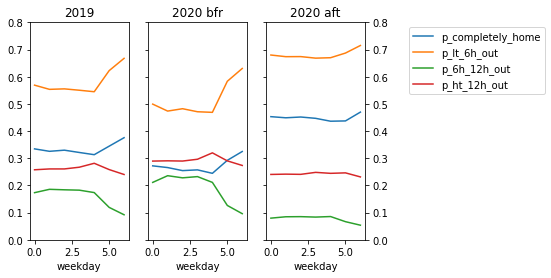

In [ ]:
selected_columns = ['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (6,4) )

weekday_2019[selected_columns].plot(ylim = (0,.8),  ax=axes[0], legend=False, title = '2019')
weekday_2020_before[selected_columns].plot(ylim = (0,.8), sharey=True, ax=axes[1], legend=False, title = '2020 bfr')
ax = weekday_2020_after[selected_columns].plot(ylim = (0,.8), sharey=True, ax=axes[2], title = '2020 aft')
ax.tick_params(labelright = True, right=True)

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax.legend(loc='upper left', bbox_to_anchor=(1.4, 1))

### Grab population/income/poverty data using census API

Let's compare socio-economic status variables vs. social distancing measures.

General description of the Census Planning Database: https://www.census.gov/topics/research/guidance/planning-databases.2019.html
* Total population: https://api.census.gov/data/2019/pdb/blockgroup/variables/Tot_Population_ACS_13_17.json
* Median household income variable: https://api.census.gov/data/2019/pdb/blockgroup/variables/Med_HHD_Inc_BG_ACS_13_17.json
* Number of people classified as below the poverty level in the ACS: https://api.census.gov/data/2019/pdb/blockgroup/variables/Prs_Blw_Pov_Lev_ACS_13_17.json
* Other available variables: https://api.census.gov/data/2019/pdb/blockgroup/variables.html

In [ ]:
import requests

census_json = requests.get("https://api.census.gov/data/2019/pdb/blockgroup" + 
                         "?get=Tot_Population_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,Prs_Blw_Pov_Lev_ACS_13_17" + 
                         "&for=block%20group:*&in=state:17%20county:031").json()

In [ ]:
cbg_info_tmp = pd.DataFrame(columns = census_json[0], data = census_json[1:])
cbg_info_tmp.info()
#cbg_info_tmp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Tot_Population_ACS_13_17   3993 non-null   object
 1   Med_HHD_Inc_BG_ACS_13_17   3834 non-null   object
 2   Prs_Blw_Pov_Lev_ACS_13_17  3993 non-null   object
 3   state                      3993 non-null   object
 4   county                     3993 non-null   object
 5   tract                      3993 non-null   object
 6   block group                3993 non-null   object
dtypes: object(7)
memory usage: 218.5+ KB


In [ ]:
import numpy as np

cbg_info_tmp['GEOID2'] = cbg_info_tmp['state'] + cbg_info_tmp['county'] + cbg_info_tmp['tract'] + cbg_info_tmp['block group']
cbg_info_tmp['pop'] = cbg_info_tmp['Tot_Population_ACS_13_17'].astype(int)
cbg_info_tmp['log_pop'] = np.log10(cbg_info_tmp['pop'])
cbg_info_tmp['hhd_inc'] = cbg_info_tmp['Med_HHD_Inc_BG_ACS_13_17'].replace('[\$,]', '', regex=True).astype(float)
cbg_info_tmp['log_inc'] = np.log10(cbg_info_tmp['hhd_inc'])
cbg_info_tmp['p_blw_pov'] = (cbg_info_tmp['Prs_Blw_Pov_Lev_ACS_13_17'].astype(int) + 1) / cbg_info_tmp['pop']
cbg_info_tmp['log_pbp'] = np.log10(cbg_info_tmp['p_blw_pov'])
cbg_info = cbg_info_tmp[['GEOID2', 'pop', 'log_pop', 'hhd_inc', 'log_inc', 'p_blw_pov', 'log_pbp']].dropna()
cbg_info.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


GEOID2   pop   log_pop  hhd_inc   log_inc  p_blw_pov   log_pbp
1  170310101002  2170  3.336460  20716.0  4.316306   0.565899 -0.247261
2  170310101003  1680  3.225309  63782.0  4.804698   0.138095 -0.859821
3  170310102011  1439  3.158061  31782.0  4.502181   0.318972 -0.496248
4  170310102012  4820  3.683047  36386.0  4.560934   0.340041 -0.468468
5  170310102013   938  2.972203  65909.0  4.818945   0.310235 -0.508310

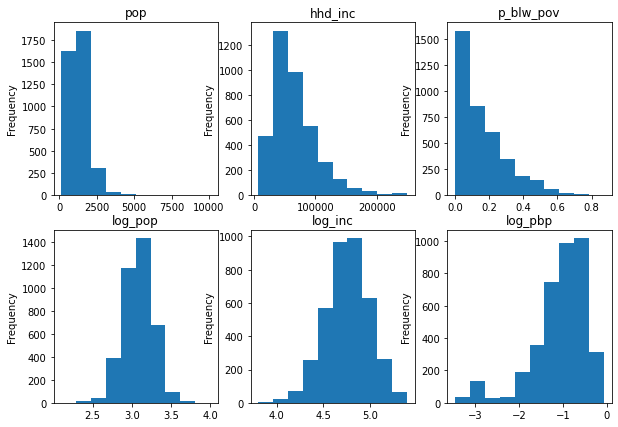

In [ ]:
# plot quick histograms

selected_columns = ['pop', 'hhd_inc', 'p_blw_pov', 'log_pop', 'log_inc', 'log_pbp']

fig, ax = plt.subplots(2,3, figsize=(10,7))
ax = ax.flatten()

for ii in range(6):
    cbg_info[selected_columns[ii]].plot(kind='hist', ax = ax[ii], title=selected_columns[ii])

### 2019 all round data


In [ ]:
# 2019 all around
cbg_mean_2019 = socdist_df[(socdist_df.date < '01-01-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2019 = cbg_mean_2019.reset_index()
cbg_mean_2019['GEOID'] = cbg_mean_2019.origin_census_block_group.astype('str')
cbg_mean_2019['log_dev'] = np.log10(cbg_mean_2019['device_count'])

# merge the social distancing and census data
cbg_mean_2019 = pd.merge(cbg_mean_2019, cbg_info, left_on='GEOID', right_on='GEOID2')
#cbg_mean_2019.head()
cbg_mean_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   origin_census_block_group    2206 non-null   int64  
 1   device_count                 2206 non-null   float64
 2   distance_traveled_from_home  2206 non-null   float64
 3   p_completely_home            2206 non-null   float64
 4   p_lt_6h_out                  2206 non-null   float64
 5   p_6h_12h_out                 2206 non-null   float64
 6   p_ht_12h_out                 2206 non-null   float64
 7   p_part_time_work             2206 non-null   float64
 8   p_full_time_work             2206 non-null   float64
 9   p_delivery                   2206 non-null   float64
 10  weekday                      2206 non-null   float64
 11  GEOID                        2206 non-null   object 
 12  log_dev                      2206 non-null   float64
 13  GEOID2            

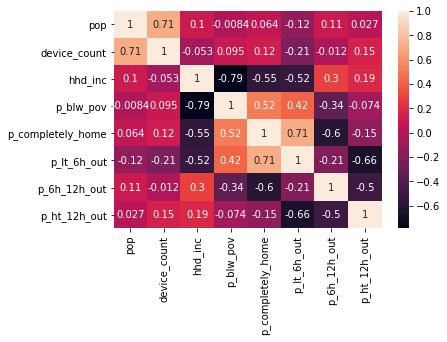

In [ ]:
selected_columns = ['pop', 'device_count', 'hhd_inc', 'p_blw_pov', 'p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']
selected_columns2 = ['log_pop', 'log_dev', 'log_inc', 'log_pbp', 'p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']

# correlations
corrMat = cbg_mean_2019[selected_columns].dropna().corr(method='spearman')
sns.heatmap(corrMat, annot=True)
plt.show()

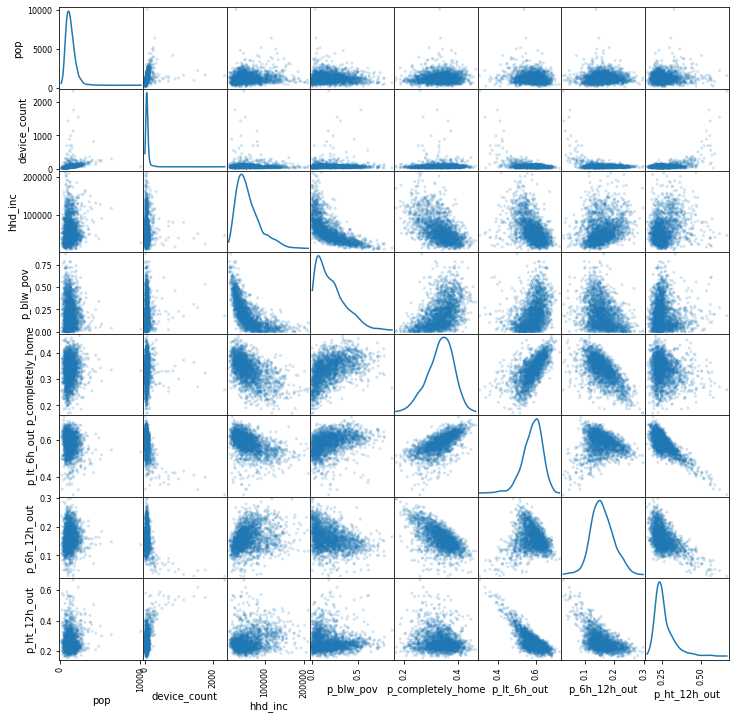

In [ ]:
# scatter plots
ax = scatter_matrix(cbg_mean_2019[selected_columns].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

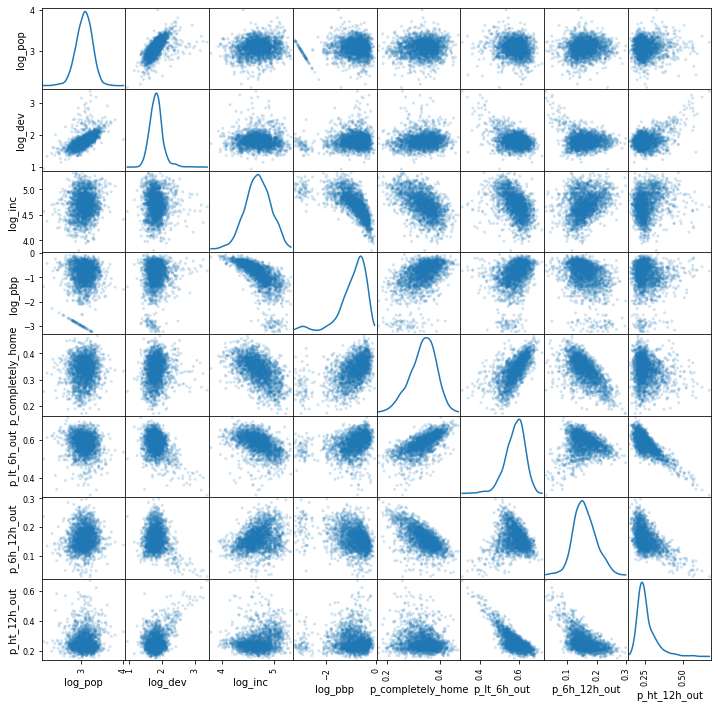

In [ ]:
# scatter plots -- logged variables
ax = scatter_matrix(cbg_mean_2019[selected_columns2].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

### 2020 before COVID (2020-01-01 to 2020-03-15)

In [ ]:
# 2020-01-01 to 2020-03-15
cbg_mean_2020_before = socdist_df[(socdist_df.date > '12-31-2019') & (socdist_df.date < '03-16-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2020_before = cbg_mean_2020_before.reset_index()
cbg_mean_2020_before['GEOID'] = cbg_mean_2020_before.origin_census_block_group.astype('str')
cbg_mean_2020_before['log_dev'] = np.log10(cbg_mean_2020_before['device_count'])

# merge the social distancing and census data
cbg_mean_2020_before = pd.merge(cbg_mean_2020_before, cbg_info, left_on='GEOID', right_on='GEOID2')
#cbg_mean_2020_before.head()
cbg_mean_2020_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   origin_census_block_group    2206 non-null   int64  
 1   device_count                 2206 non-null   float64
 2   distance_traveled_from_home  2206 non-null   float64
 3   p_completely_home            2206 non-null   float64
 4   p_lt_6h_out                  2206 non-null   float64
 5   p_6h_12h_out                 2206 non-null   float64
 6   p_ht_12h_out                 2206 non-null   float64
 7   p_part_time_work             2206 non-null   float64
 8   p_full_time_work             2206 non-null   float64
 9   p_delivery                   2206 non-null   float64
 10  weekday                      2206 non-null   float64
 11  GEOID                        2206 non-null   object 
 12  log_dev                      2206 non-null   float64
 13  GEOID2            

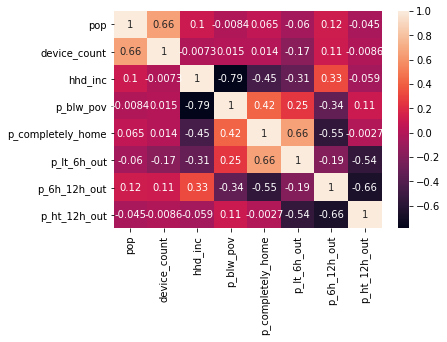

In [ ]:
# correlations
corrMat = cbg_mean_2020_before[selected_columns].dropna().corr(method='spearman')
sns.heatmap(corrMat, annot=True)
plt.show()

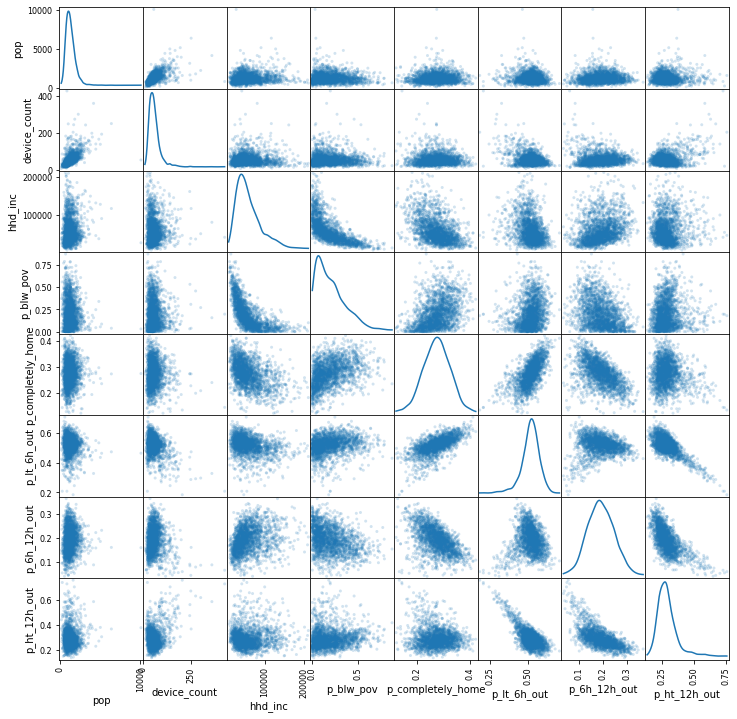

In [ ]:
# scatter plots
ax = scatter_matrix(cbg_mean_2020_before[selected_columns].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

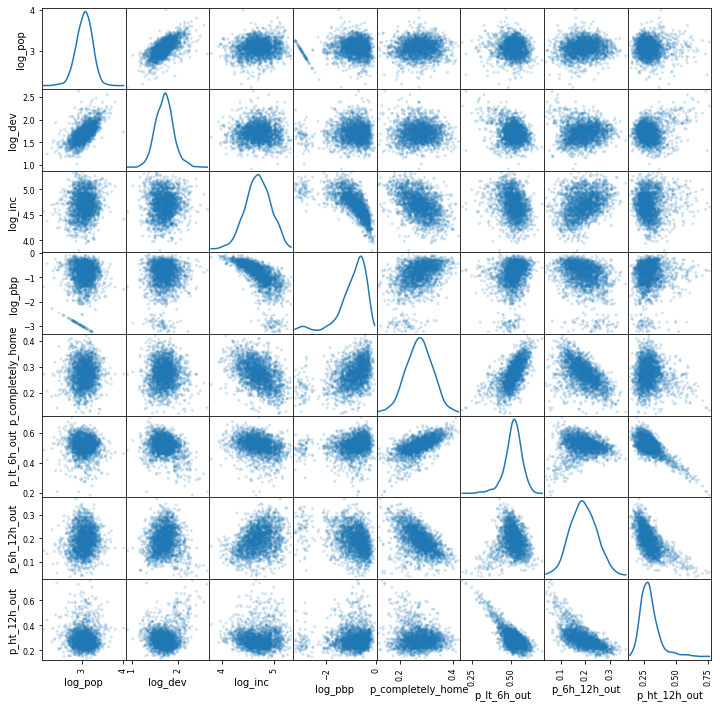

In [ ]:
# scatter plots -- logged variables
ax = scatter_matrix(cbg_mean_2020_before[selected_columns2].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

### 2020 after COVID (2020-04-01 and after)

In [ ]:
# 2020-04-01 and after
cbg_mean_2020_after = socdist_df[(socdist_df.date > '03-31-2020')].groupby('origin_census_block_group').mean()
cbg_mean_2020_after = cbg_mean_2020_after.reset_index()
cbg_mean_2020_after['GEOID'] = cbg_mean_2020_after.origin_census_block_group.astype('str')
cbg_mean_2020_after['log_dev'] = np.log10(cbg_mean_2020_after['device_count'])

# merge the social distancing and census data
cbg_mean_2020_after = pd.merge(cbg_mean_2020_after, cbg_info, left_on='GEOID', right_on='GEOID2')
#cbg_mean_2020_after.head()
cbg_mean_2020_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2205 entries, 0 to 2204
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   origin_census_block_group    2205 non-null   int64  
 1   device_count                 2205 non-null   float64
 2   distance_traveled_from_home  2205 non-null   float64
 3   p_completely_home            2205 non-null   float64
 4   p_lt_6h_out                  2205 non-null   float64
 5   p_6h_12h_out                 2205 non-null   float64
 6   p_ht_12h_out                 2205 non-null   float64
 7   p_part_time_work             2205 non-null   float64
 8   p_full_time_work             2205 non-null   float64
 9   p_delivery                   2205 non-null   float64
 10  weekday                      2205 non-null   float64
 11  GEOID                        2205 non-null   object 
 12  log_dev                      2205 non-null   float64
 13  GEOID2            

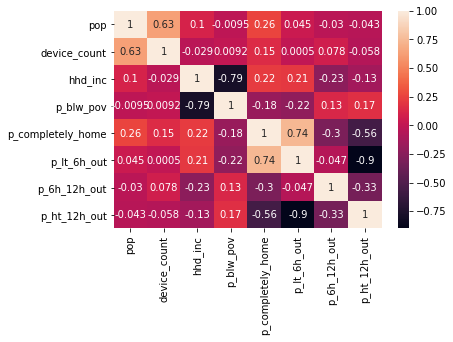

In [ ]:
# correlations
corrMat = cbg_mean_2020_after[selected_columns].dropna().corr(method='spearman')
sns.heatmap(corrMat, annot=True)
plt.show()

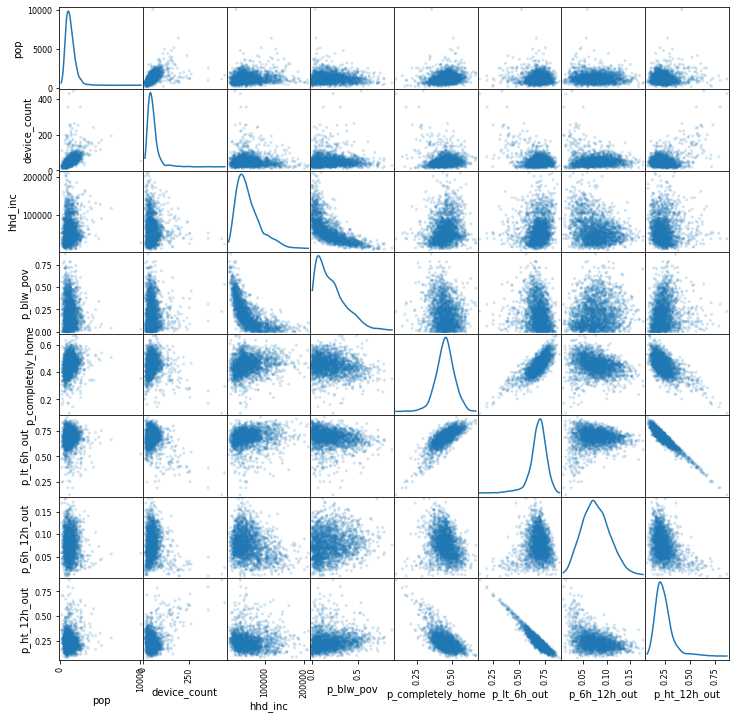

In [ ]:
# scatter plots
ax = scatter_matrix(cbg_mean_2020_after[selected_columns].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

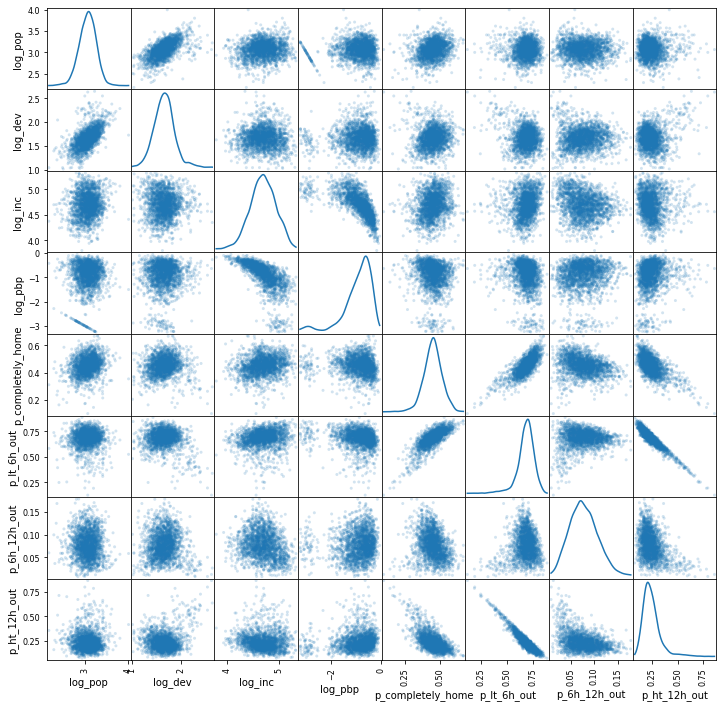

In [ ]:
# scatter plots -- logged variables
ax = scatter_matrix(cbg_mean_2020_after[selected_columns2].dropna(),
                    alpha=0.2, figsize=(12,12), diagonal='kde')

### The relationship between HHD income and % stay-home before and after COVID

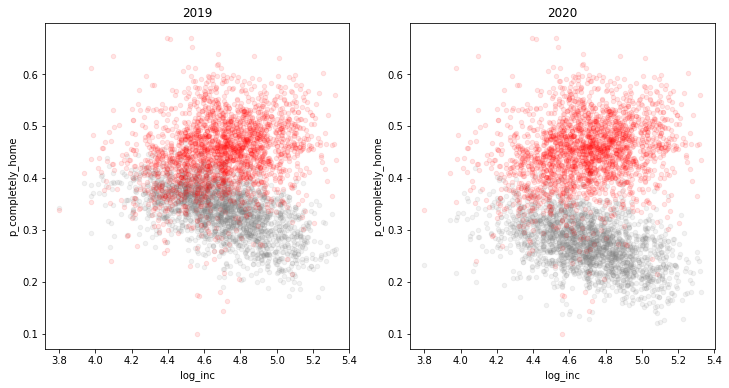

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

cbg_mean_2019.plot(kind='scatter', x='log_inc', y='p_completely_home', color='gray', alpha=0.1, ax = axes[0])
cbg_mean_2020_after.plot(kind='scatter', x='log_inc', y='p_completely_home', color='r', alpha=0.1, ax = axes[0], title='2019')

# before COVID, the poorer, the higher the stay-home rate
# after COVID, the richer, the higher the stay-home rate (reversed pattern)
cbg_mean_2020_before.plot(kind='scatter', x='log_inc', y='p_completely_home', color='gray', alpha=0.1, ax = axes[1])
cbg_mean_2020_after.plot(kind='scatter', x='log_inc', y='p_completely_home', color='r', alpha=0.1, ax = axes[1], title='2020')

In [ ]:
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f414738bc88>,
      dtype=object)

### Prep for visualizing spatial patterns

In [ ]:
# divide by the mean to get the overall distribution
selected_columns = ['p_completely_home', 'p_lt_6h_out', 'p_6h_12h_out', 'p_ht_12h_out']

# r_*: each census block group divided by the mean of all CBGs
# z_*: z-scored CBG values
for col in selected_columns:
    cbg_mean_2019['r_' + col] = cbg_mean_2019[col] / cbg_mean_2019[col].mean()
    cbg_mean_2019['z_' + col] = (cbg_mean_2019[col] - cbg_mean_2019[col].mean()) / cbg_mean_2019[col].std()
    
    cbg_mean_2020_before['r_' + col] = cbg_mean_2020_before[col] / cbg_mean_2020_before[col].mean()
    cbg_mean_2020_before['z_' + col] = (cbg_mean_2020_before[col] - cbg_mean_2020_before[col].mean()) / cbg_mean_2020_before[col].std()
    
    cbg_mean_2020_after['r_' + col] = cbg_mean_2020_after[col] / cbg_mean_2020_after[col].mean()
    cbg_mean_2020_after['z_' + col] = (cbg_mean_2020_after[col] - cbg_mean_2020_after[col].mean()) / cbg_mean_2020_after[col].std()

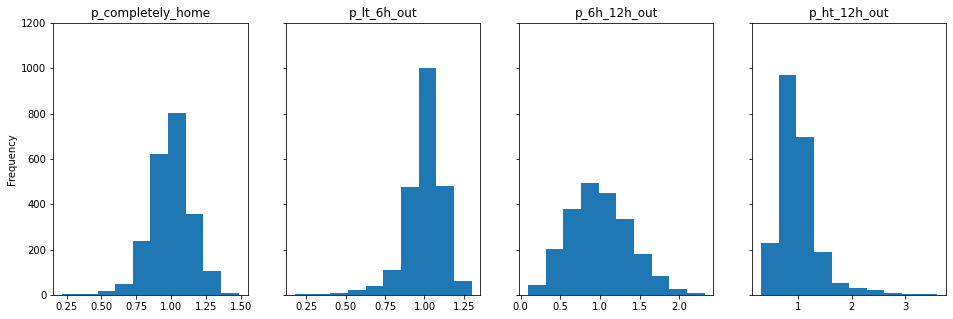

In [ ]:
fig, ax = plt.subplots(1,len(selected_columns), figsize=(16,5))
for ii in range(len(selected_columns)):
    cbg_mean_2020_after['r_' + selected_columns[ii]].\
      plot(kind='hist', ylim = (0,1200), sharey=True, ax = ax[ii], title=selected_columns[ii])


In [ ]:
# prepare for mapping
cbg_gdf_2019 = pd.merge(chi_cbg, cbg_mean_2019, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

cbg_gdf_2020_before = pd.merge(chi_cbg, cbg_mean_2020_before, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

cbg_gdf_2020_after = pd.merge(chi_cbg, cbg_mean_2020_after, 
                       left_on = "GEOID", right_on = "GEOID", 
                       how = "right")

### The proportion of completely_home

* Scaled from 0.2 (blue) - 0.6 (red)
* The 2019 map seems to follow the socio-economic status

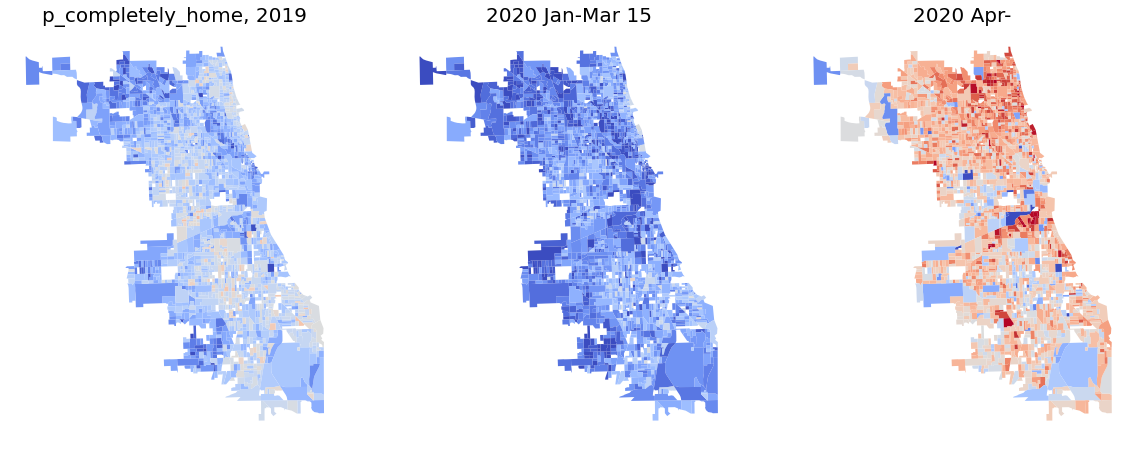

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,14))

ii = 0
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.2, vmax = 0.6, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1

### The proportion of less than 6-hour outside home

* Scaled from 0.4 (blue) - 0.8 (red)
* The 2019 map seems to follow the socio-economic status

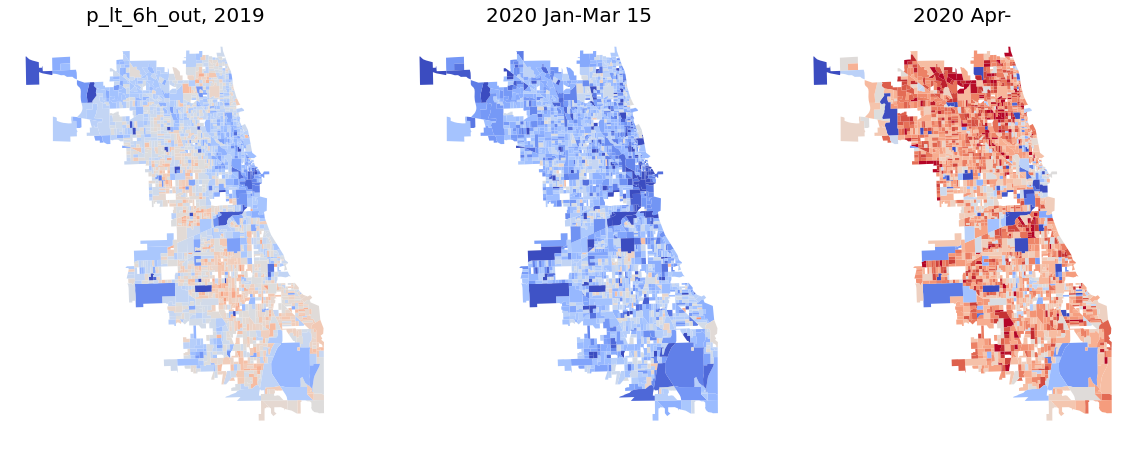

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 1
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.4, vmax = 0.8, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1


### The proportion of 6-12 hours outside home

* Scaled from 0.0 (blue) - 0.3 (red)
* The pre-corona map seems to resemble full-time employment?

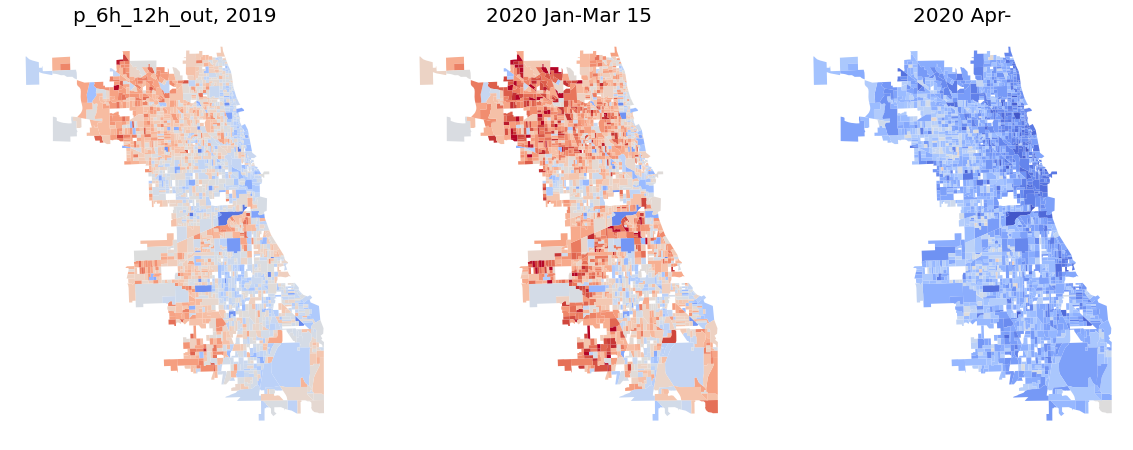

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 2
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.0, vmax = 0.3, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1

### The proportion of 12-24 hours outside home

* Scaled from 0.1 (blue) - 0.6 (red)
* Red regions include airport, medical districts, etc?

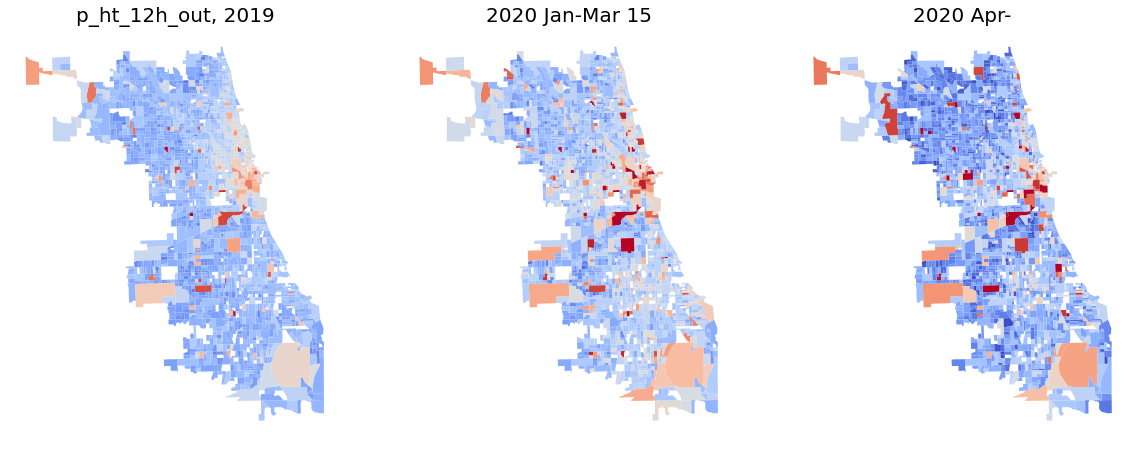

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,12))

ii = 3
ij = 0

year = ['2019', '2020 Jan-Mar 15', '2020 Apr-']

for gdf in [cbg_gdf_2019, cbg_gdf_2020_before, cbg_gdf_2020_after]:
    bx = gdf.plot(column = selected_columns[ii], 
        vmin = 0.1, vmax = 0.6, cmap = "coolwarm", ax = ax[ij])
   
    if (ij == 0):
        bx.set_title(selected_columns[ii] + ', ' + year[ij], fontsize=20)
    else:
        bx.set_title(year[ij], fontsize=20)
    bx.xaxis.set_major_locator(plt.NullLocator())
    bx.yaxis.set_major_locator(plt.NullLocator())
    bx.set_axis_off()
    bx.set_axis_on()
    for a in ["bottom", "top", "right", "left"]:
        bx.spines[a].set_linewidth(0)
    ij += 1